# Centralized AI Model Evaluation
In order to evaluate which model to use for On-Device-Training, the different models will be tested in this notebook centrally and the resutls can be compared to the already existing federated learning models. The data used for this is the same as the data for the federated learning approach, but the data will be merged into a single file.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

## Preprocessing data

In [3]:
data0 = pd.read_csv("data/fam2kbw.csv",sep=";", header=0)
data1 = pd.read_csv("data/2parents2children.csv",sep=";", header=0)
data2 = pd.read_csv("data/couplework.csv",sep=";", header=0)
data3 = pd.read_csv("data/family3kids.csv",sep=";", header=0)
data4 = pd.read_csv("data/flatsharing.csv",sep=";", header=0)
data5 = pd.read_csv("data/noworkmom.csv",sep=";", header=0)
data6 = pd.read_csv("data/philosophy2.csv",sep=";", header=0)
data7 = pd.read_csv("data/retiredcouple.csv",sep=";", header=0)
data8 = pd.read_csv("data/shiftworker1.csv",sep=";", header=0)
data9 = pd.read_csv("data/singleman.csv",sep=";", header=0)
data10 = pd.read_csv("data/singlemom1k.csv",sep=";", header=0)

In [4]:
data0 = data0["Sum [kWh]"]
data1 = data1["Sum [kWh]"]
data2 = data2["Sum [kWh]"]
data3 = data3["Sum [kWh]"]
data4 = data4["Sum [kWh]"]
data5 = data5["Sum [kWh]"]
data6 = data6["Sum [kWh]"]
data7 = data7["Sum [kWh]"]
data8 = data8["Sum [kWh]"]
data9 = data9["Sum [kWh]"]
data10 = data10["Sum [kWh]"]

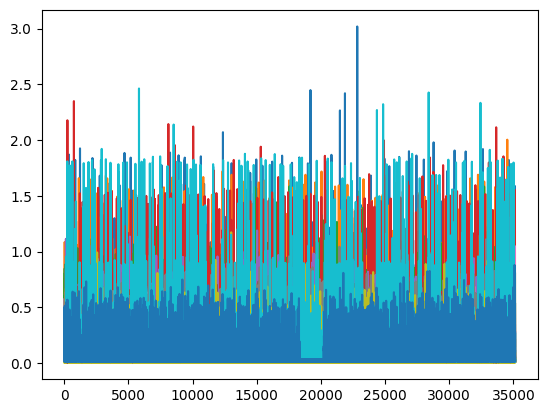

In [5]:
plt.plot(data0)
plt.plot(data1)
plt.plot(data2)
plt.plot(data3)
plt.plot(data4)
plt.plot(data5)
plt.plot(data6)
plt.plot(data7)
plt.plot(data8)
plt.plot(data9)
plt.plot(data10)

In [6]:
data = [*data1, *data2, *data3, *data4, *data5, *data6, *data7, *data8, *data9, *data10, *data0]
data = np.array(data)

In [7]:
MEAN = np.mean(data)
STD = np.std(data)
WINDOW_SIZE = 4
MEAN, STD

(0.09631261271451232, 0.16594648515012386)

In [868]:
# xs = (x - MEAN) / STD
# x = (xs * STD) + MEAN

In [8]:
def get_X_Y(data, padding=True):
    if padding:
        for i in range(0,WINDOW_SIZE):
            data.insert(0, 0.0)
    X = []
    Y = []


    for i in range(len(data)-WINDOW_SIZE):
        r = [[a] for a in data[i:i+WINDOW_SIZE]]
        X.append(r)
        next = data[i+WINDOW_SIZE]
        Y.append(next)
    X, Y = np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)

    return X, Y

In [9]:
data0 = pd.Series.tolist(data0)
data1 = pd.Series.tolist(data1)
data2 = pd.Series.tolist(data2)
data3 = pd.Series.tolist(data3)
data4 = pd.Series.tolist(data4)
data5 = pd.Series.tolist(data5)
data6 = pd.Series.tolist(data6)
data7 = pd.Series.tolist(data7)
data8 = pd.Series.tolist(data8)
data9 = pd.Series.tolist(data9)
data10 = pd.Series.tolist(data10)

In [10]:
X_0, Y_0 = get_X_Y(data0, padding=False)
X_1, Y_1 = get_X_Y(data1)
X_2, Y_2 = get_X_Y(data2)
X_3, Y_3 = get_X_Y(data3)
X_4, Y_4 = get_X_Y(data4)
X_5, Y_5 = get_X_Y(data5)
X_6, Y_6 = get_X_Y(data6)
X_7, Y_7 = get_X_Y(data7)
X_8, Y_8 = get_X_Y(data8)
X_9, Y_9 = get_X_Y(data9)
X_10, Y_10 = get_X_Y(data10)

In [42]:
X_1[1], Y_1[0], data1[0:5]

(array([[0.],
        [0.],
        [0.],
        [0.]], dtype=float32),
 0.032300007,
 [0.0, 0.0, 0.0, 0.0, 0.032300008361776794])

In [11]:
train_X = [*X_1, *X_2, *X_3,*X_4, *X_5, *X_6, *X_7, *X_8, *X_9, *X_10]
train_X = np.array(train_X)

train_Y = [*Y_1, *Y_2, *Y_3,*Y_4, *Y_5, *Y_6, *Y_7, *Y_8, *Y_9, *Y_10]
train_Y = np.array(train_Y)


test_X = [*X_0]
test_X =np.array(test_X)

test_Y = [*Y_0]
test_Y = np.array(test_Y)

In [12]:
# Standardize
train_X =  (train_X - MEAN) / STD
train_Y =  (train_Y - MEAN) / STD

test_X = (test_X - MEAN) / STD
test_Y =  (test_Y - MEAN) / STD

## Training the models with the aggregated dataset

In [29]:
LEARNING_RATE =0.1
BATCH_SIZE = 512
EPOCHS = 5

### Model 1

In [875]:
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=(WINDOW_SIZE,1)))
model1.add(tf.keras.layers.LSTM(32))
model1.add(tf.keras.layers.Dense(1))

model1.summary()

opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
metric = tf.keras.losses.MeanSquaredError()

model1.compile(loss=metric, optimizer=opt, metrics=[metric])

Model: "sequential_130"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_74 (LSTM)              (None, 12, 32)            4352      
                                                                 
 lstm_75 (LSTM)              (None, 32)                8320      
                                                                 
 dense_93 (Dense)            (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [876]:
history1 = model1.fit(x=train_X, y=train_Y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(test_X, test_Y))

Epoch 1/5
687/687 [==============================] - 70s 89ms/step - loss: 0.4735 - mean_squared_error: 0.4734 - val_loss: 1.0912 - val_mean_squared_error: 1.0909
Epoch 2/5
687/687 [==============================] - 68s 99ms/step - loss: 0.4289 - mean_squared_error: 0.4288 - val_loss: 1.0639 - val_mean_squared_error: 1.0637
Epoch 3/5
687/687 [==============================] - 100s 146ms/step - loss: 0.4204 - mean_squared_error: 0.4204 - val_loss: 1.0401 - val_mean_squared_error: 1.0397
Epoch 4/5
687/687 [==============================] - 101s 148ms/step - loss: 0.4165 - mean_squared_error: 0.4171 - val_loss: 0.9840 - val_mean_squared_error: 0.9839
Epoch 5/5
687/687 [==============================] - 94s 136ms/step - loss: 0.4129 - mean_squared_error: 0.4128 - val_loss: 1.0179 - val_mean_squared_error: 1.0178


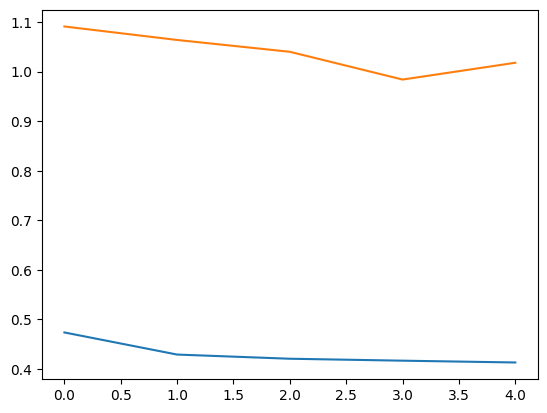

In [877]:
plt.plot(history1.history["loss"])
plt.plot(history1.history["val_loss"])

In [878]:
predictions1 = model1.predict(test_X).flatten()
results1 = pd.DataFrame(data={"Predicted Values": predictions1, "Actual Values": test_Y})

In [879]:
temp_results1 = (results1 * STD) + MEAN

mapeObject = tf.keras.losses.MeanAbsolutePercentageError()
mapeTensor = mapeObject(temp_results1["Actual Values"][:-1], temp_results1["Predicted Values"][1:])
mape = mapeTensor.numpy()

maeObject = tf.keras.losses.MeanAbsoluteError()
maeTensor = maeObject(temp_results1["Actual Values"][:-1], temp_results1["Predicted Values"][1:])
mae = maeTensor.numpy()

mseObject = tf.keras.losses.MeanSquaredError()
mseTensor = mseObject(temp_results1["Actual Values"][:-1], temp_results1["Predicted Values"][1:])
mse = mseTensor.numpy()

rmseObject = tf.keras.metrics.RootMeanSquaredError()
rmseTensor = rmseObject(temp_results1["Actual Values"][:-1], temp_results1["Predicted Values"][1:])
rmse = rmseTensor.numpy()

print("Loss: ", mse)
print("MAPE: ", mape)
print("MAE: ", mae)
print("RMSE: ", rmse)

Loss:  0.024840472266077995
MAPE:  54.57478713989258
MAE:  0.07071881741285324
RMSE:  0.1576086


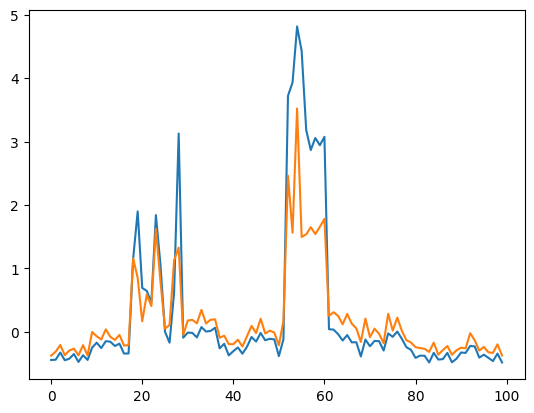

In [880]:
plt.plot(results1["Actual Values"][0:100].values)
plt.plot(results1["Predicted Values"][1:101].values)

In [881]:
temp_results1

,Predicted Values,Actual Values
0,0.064140,0.023048
1,0.034393,0.023682
2,0.044739,0.042498
3,0.062247,0.022293
4,0.035613,0.026395
...,...,...
35119,0.099599,0.043212
35120,0.065101,0.022902
35121,0.053641,0.042044
35122,0.063749,0.016663


### Model 2

In [882]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True), input_shape=(WINDOW_SIZE, 1)))
model2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
model2.add(tf.keras.layers.Dense(32))
model2.add(tf.keras.layers.Dense(32))
model2.add(tf.keras.layers.Dense(1))

model2.summary()

opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
metric = tf.keras.losses.MeanSquaredError()

model2.compile(loss=metric, optimizer=opt, metrics=[metric])

Model: "sequential_131"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirecti  (None, 12, 64)           8704      
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 64)               24832     
 onal)                                                           
                                                                 
 dense_94 (Dense)            (None, 32)                2080      
                                                                 
 dense_95 (Dense)            (None, 32)                1056      
                                                                 
 dense_96 (Dense)            (None, 1)                 33        
                                                                 
Total params: 36,705
Trainable params: 36,705
Non-tr

In [883]:
history2 = model2.fit(train_X, train_X, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(test_X, test_Y))

Epoch 1/5
687/687 [==============================] - 170s 228ms/step - loss: 0.5462 - mean_squared_error: 0.5463 - val_loss: 1.9361 - val_mean_squared_error: 1.9335
Epoch 2/5
687/687 [==============================] - 157s 228ms/step - loss: 0.5446 - mean_squared_error: 0.5444 - val_loss: 1.9519 - val_mean_squared_error: 1.9492
Epoch 3/5
687/687 [==============================] - 161s 235ms/step - loss: 0.5447 - mean_squared_error: 0.5449 - val_loss: 1.9298 - val_mean_squared_error: 1.9272
Epoch 4/5
687/687 [==============================] - 136s 198ms/step - loss: 0.5448 - mean_squared_error: 0.5450 - val_loss: 1.9297 - val_mean_squared_error: 1.9271
Epoch 5/5
687/687 [==============================] - 157s 228ms/step - loss: 0.5446 - mean_squared_error: 0.5445 - val_loss: 1.9427 - val_mean_squared_error: 1.9401


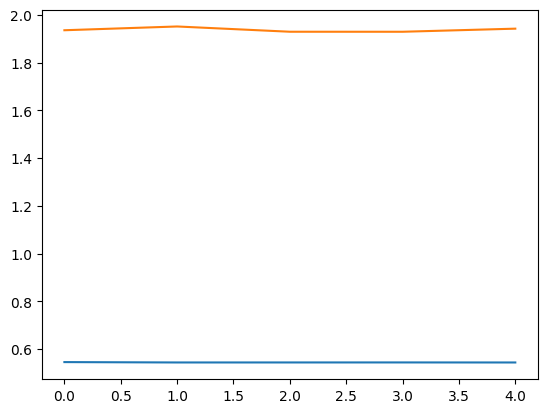

In [884]:
plt.plot(history2.history["loss"])
plt.plot(history2.history["val_loss"])

In [885]:
predictions2 = model2.predict(test_X).flatten()
results2 = pd.DataFrame(data={"Predicted Values": predictions2, "Actual Values": test_Y})

In [886]:
temp_results2 = (results2 * STD) + MEAN

mapeObject = tf.keras.losses.MeanAbsolutePercentageError()
mapeTensor = mapeObject(temp_results2["Actual Values"][:-1], temp_results2["Predicted Values"][1:])
mape = mapeTensor.numpy()

maeObject = tf.keras.losses.MeanAbsoluteError()
maeTensor = maeObject(temp_results2["Actual Values"][:-1], temp_results2["Predicted Values"][1:])
mae = maeTensor.numpy()

mseObject = tf.keras.losses.MeanSquaredError()
mseTensor = mseObject(temp_results2["Actual Values"][:-1], temp_results2["Predicted Values"][1:])
mse = mseTensor.numpy()

rmseObject = tf.keras.metrics.RootMeanSquaredError()
rmseTensor = rmseObject(temp_results2["Actual Values"][:-1], temp_results2["Predicted Values"][1:])
rmse = rmseTensor.numpy()

print("Loss: ", mse)
print("MAPE: ", mape)
print("MAE: ", mae)
print("RMSE: ", rmse)

Loss:  0.04441395774483681
MAPE:  124.13130950927734
MAE:  0.12168416380882263
RMSE:  0.2107462


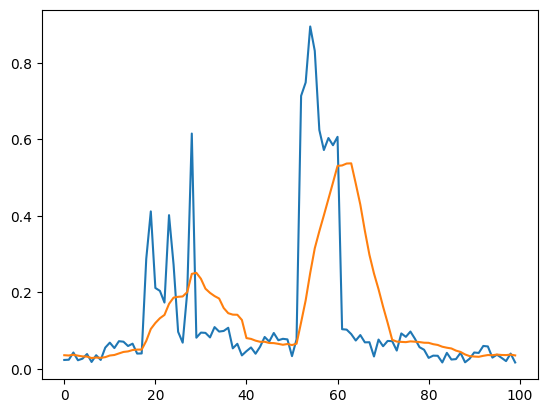

In [887]:
plt.plot(temp_results2["Actual Values"][0:100].values)
plt.plot(temp_results2["Predicted Values"][1:101].values)

In [888]:
results2

,Predicted Values,Actual Values
0,-0.365908,-0.441495
1,-0.366654,-0.437676
2,-0.371027,-0.324290
3,-0.358894,-0.446047
4,-0.373651,-0.421328
...,...,...
35119,-0.090249,-0.319984
35120,-0.120497,-0.442378
35121,-0.159646,-0.327026
35122,-0.196533,-0.479972


### Model 3

In [889]:
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.InputLayer((WINDOW_SIZE, 1)))
model3.add(tf.keras.layers.LSTM(32))
model3.add(tf.keras.layers.Dense(1))


model3.summary()

opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
metric = tf.keras.losses.MeanSquaredError()

model3.compile(loss=metric, optimizer=opt, metrics=[metric])

Model: "sequential_132"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_78 (LSTM)              (None, 32)                4352      
                                                                 
 dense_97 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [890]:
history3 = model3.fit(train_X, train_Y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(test_X, test_Y))

Epoch 1/5
687/687 [==============================] - 71s 100ms/step - loss: 0.4889 - mean_squared_error: 0.4886 - val_loss: 1.0622 - val_mean_squared_error: 1.0621
Epoch 2/5
687/687 [==============================] - 70s 101ms/step - loss: 0.4345 - mean_squared_error: 0.4344 - val_loss: 1.0717 - val_mean_squared_error: 1.0718
Epoch 3/5
687/687 [==============================] - 53s 77ms/step - loss: 0.4245 - mean_squared_error: 0.4244 - val_loss: 1.0104 - val_mean_squared_error: 1.0100
Epoch 4/5
687/687 [==============================] - 89s 129ms/step - loss: 0.4204 - mean_squared_error: 0.4204 - val_loss: 1.0034 - val_mean_squared_error: 1.0031
Epoch 5/5
687/687 [==============================] - 206s 299ms/step - loss: 0.4162 - mean_squared_error: 0.4161 - val_loss: 0.9762 - val_mean_squared_error: 0.9759


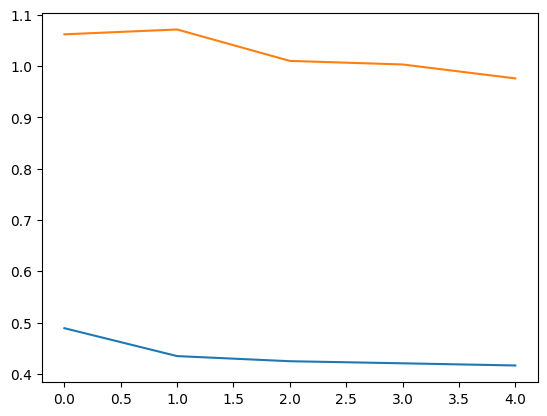

In [891]:
plt.plot(history3.history["loss"])
plt.plot(history3.history["val_loss"])

In [892]:
predictions3 = model3.predict(test_X).flatten()
results3 = pd.DataFrame(data={"Predicted Values": predictions3, "Actual Values": test_Y})

In [893]:
temp_results3 = (results3 * STD) + MEAN

mapeObject = tf.keras.losses.MeanAbsolutePercentageError()
mapeTensor = mapeObject(temp_results3["Actual Values"][:-1], temp_results3["Predicted Values"][1:])
mape = mapeTensor.numpy()

maeObject = tf.keras.losses.MeanAbsoluteError()
maeTensor = maeObject(temp_results3["Actual Values"][:-1], temp_results3["Predicted Values"][1:])
mae = maeTensor.numpy()

mseObject = tf.keras.losses.MeanSquaredError()
mseTensor = mseObject(temp_results3["Actual Values"][:-1], temp_results3["Predicted Values"][1:])
mse = mseTensor.numpy()

rmseObject = tf.keras.metrics.RootMeanSquaredError()
rmseTensor = rmseObject(temp_results3["Actual Values"][:-1], temp_results3["Predicted Values"][1:])
rmse = rmseTensor.numpy()

print("Loss: ", mse)
print("MAPE: ", mape)
print("MAE: ", mae)
print("RMSE: ", rmse)

Loss:  0.022801661863923073
MAPE:  38.64291000366211
MAE:  0.06263798475265503
RMSE:  0.1510022


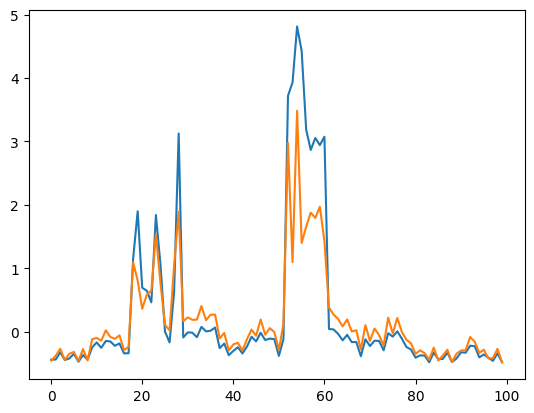

In [894]:
plt.plot(results3["Actual Values"][0:100].values)
plt.plot(results3["Predicted Values"][1:101].values)

### Model 4

In [35]:
model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.LSTM(32, activation="tanh", dropout=0.1, return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
model4.add(tf.keras.layers.LSTM(16, activation="tanh", dropout=0.1))
model4.add(tf.keras.layers.Dense(1))

model4.summary()

opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
metric = tf.keras.losses.MeanAbsoluteError()

model4.compile(loss=metric, optimizer=opt, metrics=[metric])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 4, 32)             4352      
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 7,505
Trainable params: 7,505
Non-trainable params: 0
_________________________________________________________________


In [36]:
history4 = model4.fit(train_X, train_Y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.8, shuffle=True)

Epoch 1/5
138/138 [==============================] - 67s 442ms/step - loss: 0.5669 - mean_absolute_error: 0.5667 - val_loss: 0.2932 - val_mean_absolute_error: 0.2929
Epoch 2/5
138/138 [==============================] - 54s 393ms/step - loss: 0.4776 - mean_absolute_error: 0.4772 - val_loss: 0.2676 - val_mean_absolute_error: 0.2672
Epoch 3/5
138/138 [==============================] - 47s 345ms/step - loss: 0.4636 - mean_absolute_error: 0.4636 - val_loss: 0.2644 - val_mean_absolute_error: 0.2640
Epoch 4/5
138/138 [==============================] - 38s 279ms/step - loss: 0.4610 - mean_absolute_error: 0.4607 - val_loss: 0.2732 - val_mean_absolute_error: 0.2728
Epoch 5/5
138/138 [==============================] - 47s 344ms/step - loss: 0.4600 - mean_absolute_error: 0.4602 - val_loss: 0.2720 - val_mean_absolute_error: 0.2717


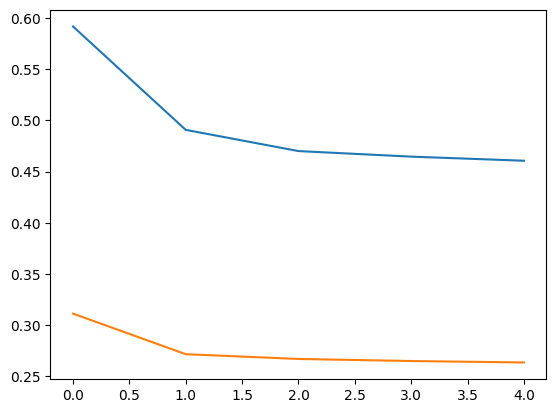

In [32]:
plt.plot(history4.history["loss"])
plt.plot(history4.history["val_loss"])

In [33]:
predictions4 = model4.predict(test_X).flatten()
results4 = pd.DataFrame(data={"Predicted Values": predictions4, "Actual Values": test_Y})

In [34]:
temp_results4 = (results4 * STD) + MEAN

mapeObject = tf.keras.losses.MeanAbsolutePercentageError()
mapeTensor = mapeObject(temp_results4["Actual Values"], temp_results4["Predicted Values"])
mape = mapeTensor.numpy()

maeObject = tf.keras.losses.MeanAbsoluteError()
maeTensor = maeObject(temp_results4["Actual Values"], temp_results4["Predicted Values"])
mae = maeTensor.numpy()

mseObject = tf.keras.losses.MeanSquaredError()
mseTensor = mseObject(temp_results4["Actual Values"], temp_results4["Predicted Values"])
mse = mseTensor.numpy()

rmseObject = tf.keras.metrics.RootMeanSquaredError()
rmseTensor = rmseObject(temp_results4["Actual Values"], temp_results4["Predicted Values"])
rmse = rmseTensor.numpy()

print("Loss: ", mse)
print("MAPE: ", mape)
print("MAE: ", mae)
print("RMSE: ", rmse)

Loss:  0.036443646997213364
MAPE:  56.37166976928711
MAE:  0.08730906248092651
RMSE:  0.19090219


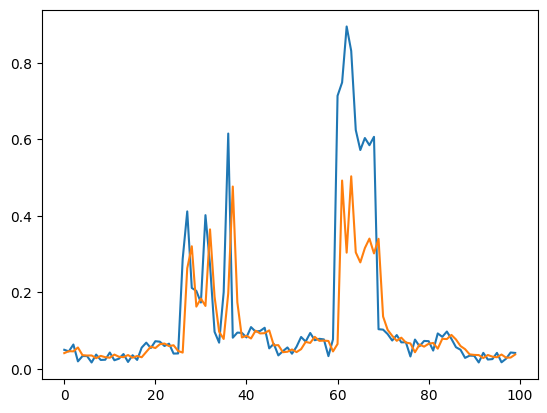

In [44]:
plt.plot(temp_results4["Actual Values"][0:100].values)
plt.plot(temp_results4["Predicted Values"][0:100].values)

In [28]:
temp_results4[120:200]

,Predicted Values,Actual Values
120,0.094759,0.524805
121,0.396776,0.266335
122,0.181445,0.332761
123,0.182678,0.163337
124,0.151775,0.174487
...,...,...
195,0.031484,0.030901
196,0.030277,0.064856
197,0.034652,0.044109
198,0.042508,0.044430


### Model 5

In [902]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(30, 1, activation="relu", input_shape=(WINDOW_SIZE, 1), strides=1))
model.add(tf.keras.layers.Conv1D(20, 2, activation="relu", strides=1))
model.add(tf.keras.layers.Conv1D(40, 3, activation="relu", strides=1))
model.add(tf.keras.layers.Conv1D(50, 1, activation="relu", strides=1))
model.add(tf.keras.layers.Dropout(.2))
model.add(tf.keras.layers.Conv1D(50, 1, activation="relu", strides=1))
model.add(tf.keras.layers.Dropout(.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(24, activation='relu'))
model.add(tf.keras.layers.Dropout(.2))
model.add(tf.keras.layers.Dense(1))

model.summary()

opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
metric = tf.keras.losses.MeanAbsoluteError()

model.compile(loss=metric, optimizer=opt, metrics=[metric])
model.input_shape, model.output_shape

Model: "sequential_134"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_208 (Conv1D)         (None, 12, 30)            60        
                                                                 
 conv1d_209 (Conv1D)         (None, 11, 20)            1220      
                                                                 
 conv1d_210 (Conv1D)         (None, 9, 40)             2440      
                                                                 
 conv1d_211 (Conv1D)         (None, 9, 50)             2050      
                                                                 
 dropout_46 (Dropout)        (None, 9, 50)             0         
                                                                 
 conv1d_212 (Conv1D)         (None, 9, 50)             2550      
                                                                 
 dropout_47 (Dropout)        (None, 9, 50)          

((None, 12, 1), (None, 1))

In [903]:
his = model.fit(train_X, train_Y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.8, shuffle=True)

Epoch 1/5
138/138 [==============================] - 31s 216ms/step - loss: 0.4844 - mean_absolute_error: 0.4843 - val_loss: 0.2827 - val_mean_absolute_error: 0.2823
Epoch 2/5
138/138 [==============================] - 28s 201ms/step - loss: 0.4559 - mean_absolute_error: 0.4561 - val_loss: 0.2835 - val_mean_absolute_error: 0.2831
Epoch 3/5
138/138 [==============================] - 27s 198ms/step - loss: 0.4494 - mean_absolute_error: 0.4492 - val_loss: 0.2731 - val_mean_absolute_error: 0.2727
Epoch 4/5
138/138 [==============================] - 23s 170ms/step - loss: 0.4449 - mean_absolute_error: 0.4451 - val_loss: 0.2661 - val_mean_absolute_error: 0.2657
Epoch 5/5
138/138 [==============================] - 44s 322ms/step - loss: 0.4436 - mean_absolute_error: 0.4437 - val_loss: 0.2780 - val_mean_absolute_error: 0.2776


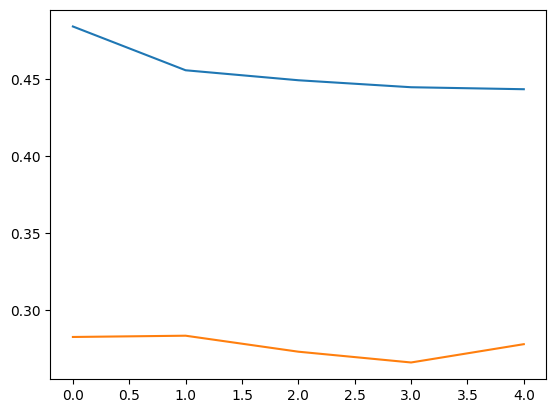

In [904]:
plt.plot(his.history["loss"])
plt.plot(his.history["val_loss"])

In [905]:
predictions5 = model.predict(test_X).flatten()
results5 = pd.DataFrame(data={"Predicted Values": predictions5, "Actual Values": test_Y})

In [906]:
temp_results5 = (results5 * STD) + MEAN

mapeObject = tf.keras.losses.MeanAbsolutePercentageError()
mapeTensor = mapeObject(temp_results5["Actual Values"][:-1], temp_results5["Predicted Values"][1:])
mape = mapeTensor.numpy()

maeObject = tf.keras.losses.MeanAbsoluteError()
maeTensor = maeObject(temp_results5["Actual Values"][:-1], temp_results5["Predicted Values"][1:])
mae = maeTensor.numpy()

mseObject = tf.keras.losses.MeanSquaredError()
mseTensor = mseObject(temp_results5["Actual Values"][:-1], temp_results5["Predicted Values"][1:])
mse = mseTensor.numpy()

rmseObject = tf.keras.metrics.RootMeanSquaredError()
rmseTensor = rmseObject(temp_results5["Actual Values"][:-1], temp_results5["Predicted Values"][1:])
rmse = rmseTensor.numpy()

print("Loss: ", mse)
print("MAPE: ", mape)
print("MAE: ", mae)
print("RMSE: ", rmse)

Loss:  0.02780674584209919
MAPE:  29.4849853515625
MAE:  0.06753808259963989
RMSE:  0.16675355


In [45]:
plt.plot(temp_results5["Actual Values"][0:100].values)
plt.plot(temp_results5["Predicted Values"][0:100].values)

NameError: name 'temp_results5' is not defined